In [1]:

import os
import re
import pickle
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold, cross_val_score
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor,GradientBoostingRegressor, 
                              RandomForestRegressor,  GradientBoostingRegressor)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

# bibliotecas de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import plotly.figure_factory as ff 
from plotly.offline import iplot
from plotly import tools

import warnings
warnings.filterwarnings("ignore")


plt.rcParams['figure.dpi'] = 100
colors = px.colors.qualitative.Prism
pio.templates.default = "plotly_white"



## Lectura de datos

In [2]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_id = test.reset_index().drop('index',axis=1)['Id']



train_df_orig = train.copy()
test_df_orig = test.copy()

full_df = pd.concat([train.set_index('Id'), test.set_index('Id')]).reset_index(drop=True)
del full_df['SalePrice']

## Visualización de datos 

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [5]:
train.info()
print('_ '*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
#Valores de cada columna 
for col in full_df.select_dtypes('O').columns:
    print(' {} valores unicos en {} : {}'.format(len(train[col].unique()),col,train[col].unique()))
    print('__'*30)

 5 valores unicos en MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
____________________________________________________________
 2 valores unicos en Street : ['Pave' 'Grvl']
____________________________________________________________
 3 valores unicos en Alley : [nan 'Grvl' 'Pave']
____________________________________________________________
 4 valores unicos en LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
____________________________________________________________
 4 valores unicos en LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
____________________________________________________________
 2 valores unicos en Utilities : ['AllPub' 'NoSeWa']
____________________________________________________________
 5 valores unicos en LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
____________________________________________________________
 3 valores unicos en LandSlope : ['Gtl' 'Mod' 'Sev']
____________________________________________________________
 25 valores unicos en Neighborhood : ['CollgCr' 'Veen

In [7]:
# correlaciones
corr = train.corr()
corr['SalePrice'].sort_values(ascending=False)[1:15].to_frame()\
.style.background_gradient(axis=1,cmap=sns.light_palette('green', as_cmap=True))

## Analisis visual 

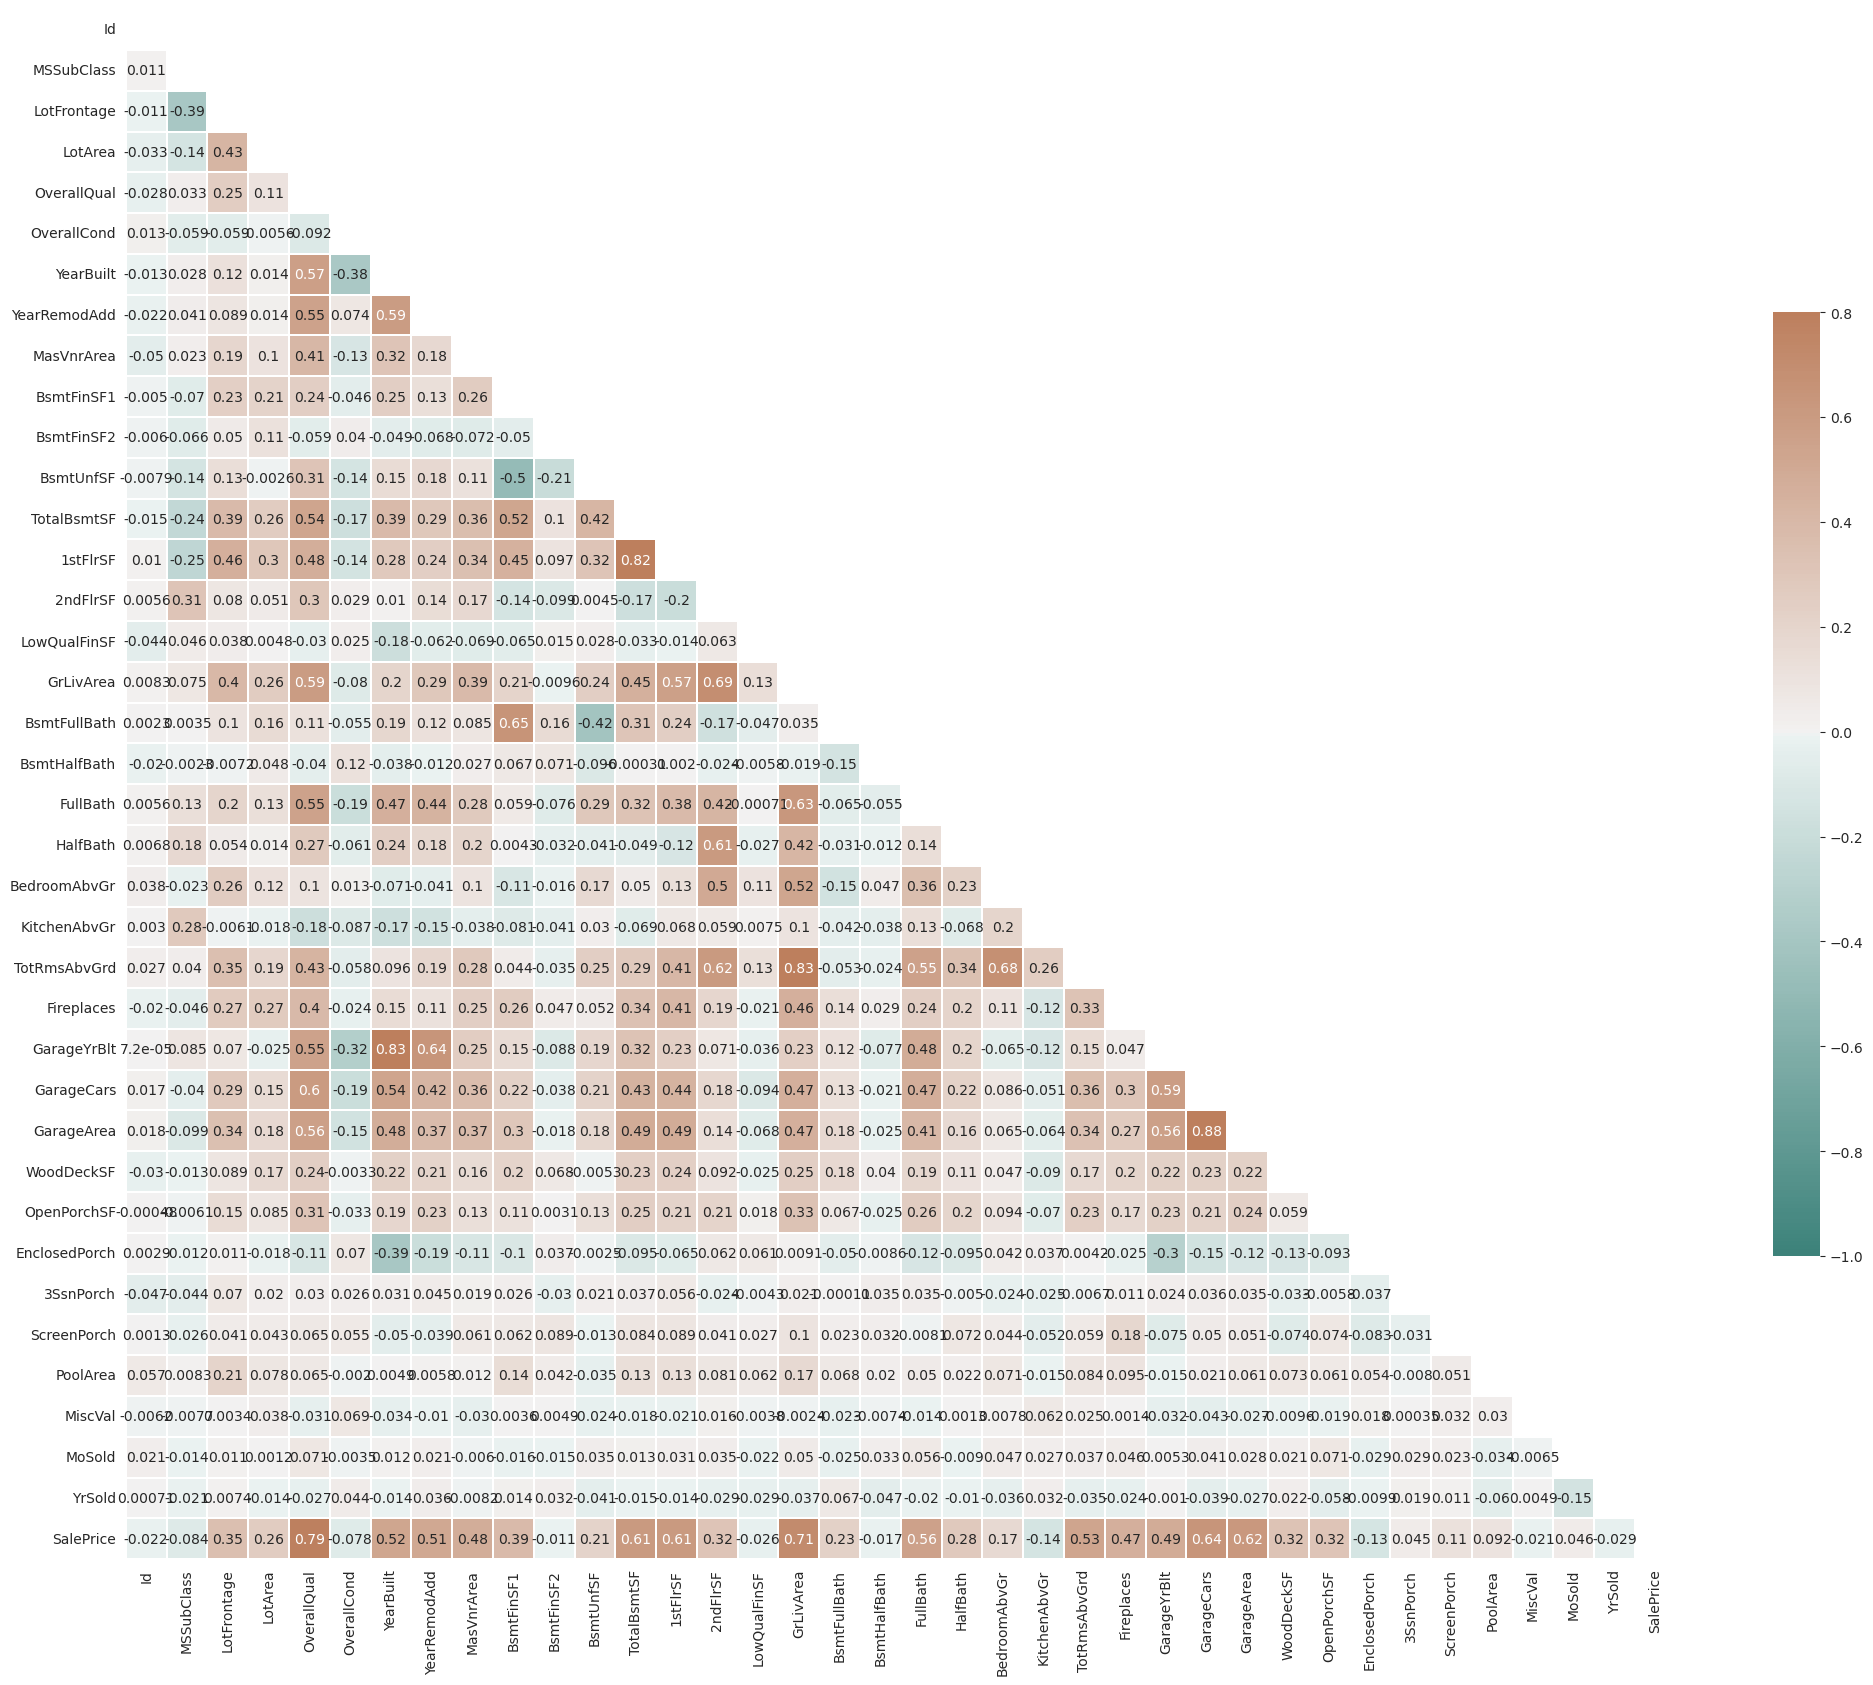

In [8]:
#  mapa de correlaciones
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(180, 30, as_cmap=True)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(25, 25))
    sns.heatmap(corr,  mask=mask, cmap=cmap, annot=True, center=0, vmin=-1, vmax=0.8,
                square=True, cbar_kws={'shrink':.5, 'orientation': 'vertical'}, linewidth=.02);

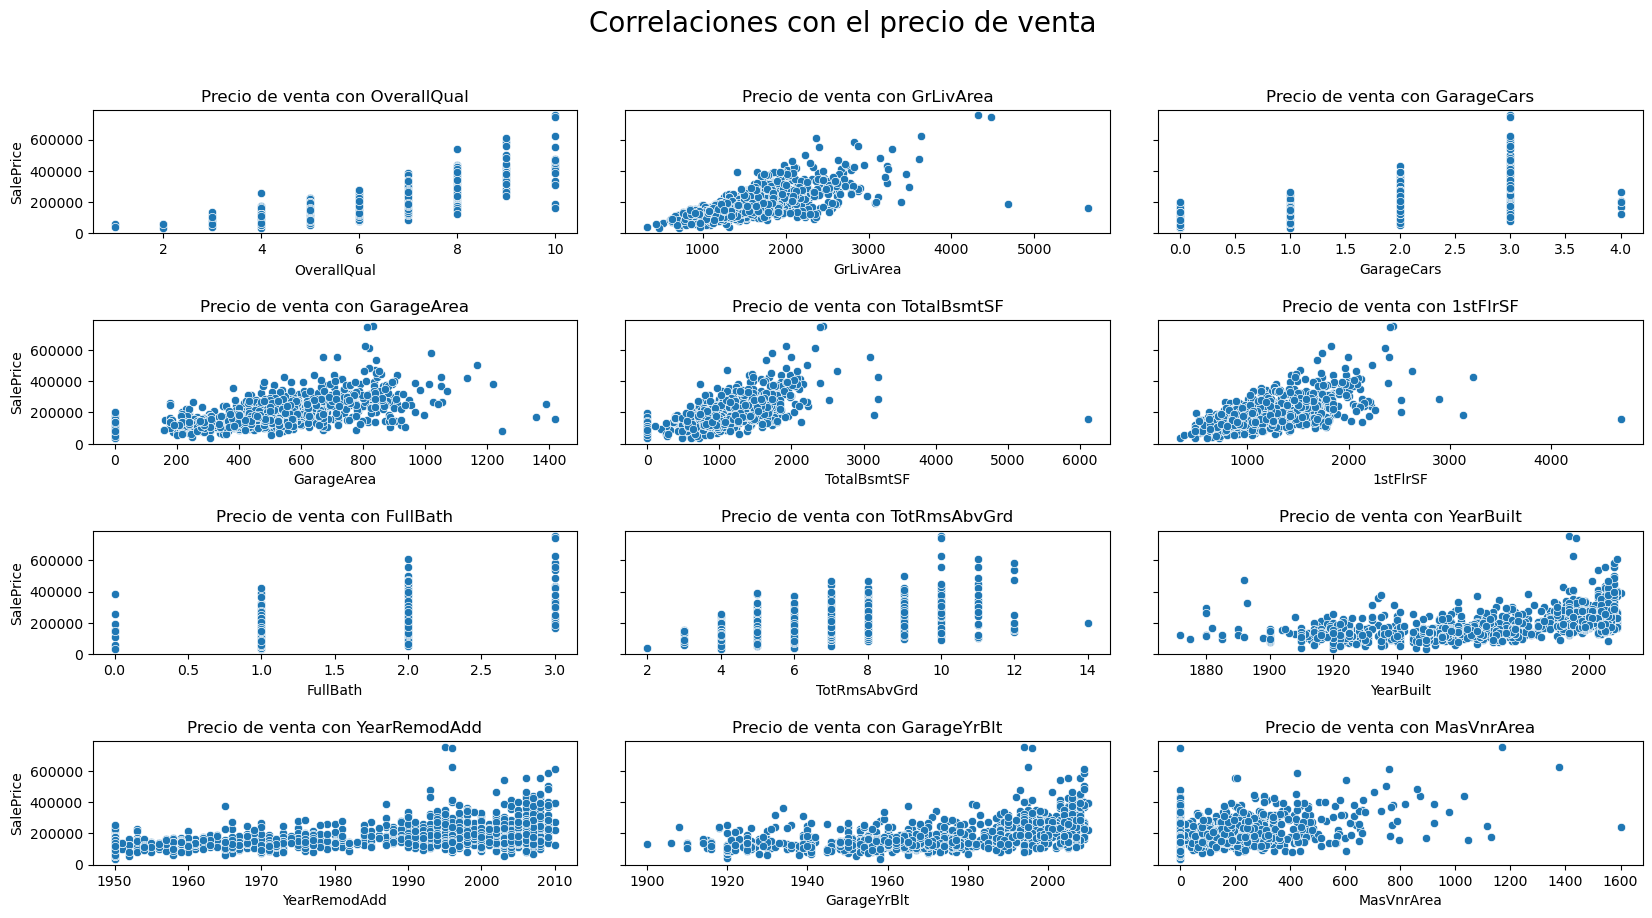

In [9]:
# Correlaciones frente el precio de venta 

high_corr = corr['SalePrice'].sort_values(ascending=False)[1:][:13].index.tolist()

fig, axes = plt.subplots(4,3, figsize=(20, 10), sharey=True);
plt.subplots_adjust(hspace = 0.7, wspace=0.1)
fig.suptitle('Correlaciones con el precio de venta', fontsize=20)

for i,col in zip(range(12),high_corr):
    sns.scatterplot(y=train['SalePrice'], x=train[col],ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title('Precio de venta con '+col)

In [10]:
# seleccionar los índices de valores atípicos de los gráficos de dispersión anteriores
drop_index = train[((train['GarageArea']>1200) & (train['SalePrice']<300000))|
                  ((train['GrLivArea']>5000) & (train['SalePrice']<300000))|
                  ((train['1stFlrSF']>4000) & (train['SalePrice']<300000))|
                  ((train['TotalBsmtSF']>5000) & (train['SalePrice']<300000))|
                  ((train['MasVnrArea']>1200) & (train['SalePrice']<700000))|
                  ((train['SalePrice']>600000))].index

In [11]:
# Para prevenir error 
cf.go_offline() 
init_notebook_mode(connected=False)    

# Distribuciones de precio de venta (SalePrice)
temp = pd.DataFrame()
temp['Precio de venta'] = train['SalePrice']
temp['logaritmo Precio de venta '] = np.log1p(train['SalePrice'])

temp.iplot(kind='hist',
           subplots=True,
           fill=True,
           subplot_titles=True,
           title='Sales Distribution')

La principal utilidad de los logaritmos para el análisis econométrico es su capacidad de eliminar el efecto de las unidades de las variables sobre los coeficientes,ademas de tener una distribución normal que que nos ayuda a la detección de valores atípicos. En estos datos, tenemos una distribución sesgada a la derecha en la que la mayoría de las ventas están entre 0 y 340K.

In [12]:
Y_train = train['SalePrice']
del train['SalePrice']

#Converting the saleprice with Logarithms to overcome the high skewness and the outliers
Y_train = np.log1p(Y_train) 

full_df = pd.concat([train.iloc[:,1:], test.iloc[:,1:]])
ntrain = len(train)
ntest = len(test)

## Valores null 

In [13]:
#porcentaje nulo para cada columna

null_df = round(100*(full_df.isnull().sum().sort_values(ascending=False)/len(full_df.index)),2)\
                    .to_frame().rename(columns={0:'Null values percentage'})[:15]
null_df

Null values percentage
PoolQC                         99.66
MiscFeature                    96.40
Alley                          93.22
Fence                          80.44
FireplaceQu                    48.65
LotFrontage                    16.65
GarageYrBlt                     5.45
GarageFinish                    5.45
GarageQual                      5.45
GarageCond                      5.45
GarageType                      5.38
BsmtExposure                    2.81
BsmtCond                        2.81
BsmtQual                        2.77
BsmtFinType2                    2.74

##  Visulizando los valores nulos en cada columna

In [14]:
# Gráfico circular valores null 

null_df.reset_index().iplot(kind='pie',labels='index',title='Porcentaje de valores nulos',textinfo='label+text+percent',values='Null values percentage')

Valores perdidos 

In [15]:
# extraeré las características (categóricas y numéricas)
num_cols = ['LotFrontage', 'LotArea', 'YearBuilt','YearRemodAdd', 'MasVnrArea', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
            'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
            'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
            '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour','LotConfig', 'LandSlope', 'Neighborhood',
            'Condition1', 'Condition2','BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st','Exterior2nd', 
            'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2','Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual','TotRmsAbvGrd', 'Functional', 
            'FireplaceQu', 'GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC','Fence', 
            'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition','OverallCond', 'YrSold']

In [16]:
null_num = full_df[num_cols].isnull().sum()[full_df[num_cols].isnull().sum()>0].index
print('Las categorías categóricas que tienen valores nulos que son : \n\n{}'.format(null_num.values))

Las categorías categóricas que tienen valores nulos que son : 

['LotFrontage' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'BsmtFullBath' 'BsmtHalfBath' 'GarageYrBlt' 'GarageCars'
 'GarageArea']


In [17]:
full_df['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

Como contienen el valor AllPub , podemos eliminarla del modelo sin ninguna alteracion . 

In [18]:
del full_df['Utilities']

Rellenar valores nulos

In [19]:
# Para el sotano 
BS_col = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
          'BsmtFullBath','MasVnrArea','BsmtHalfBath','BsmtFinSF1', 
          'BsmtFinSF2', 'BsmtUnfSF']

# sin sotano
for col in BS_col:
    full_df[col].fillna(0, inplace=True)     
full_df['BsmtCond'].fillna('NA', inplace=True)     
full_df['BsmtExposure'].fillna('NA', inplace=True)    
full_df['BsmtQual'].fillna('NA', inplace=True)        
full_df['BsmtFinType1'].fillna('NA', inplace=True)   
full_df['BsmtFinType2'].fillna('NA', inplace=True)
# Garaje 
gr_col = ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
# Sin garaje
full_df['GarageYrBlt'].fillna(0, inplace=True)
full_df['GarageCars'].fillna(0, inplace=True)          
full_df['GarageArea'].fillna(0, inplace=True)
full_df['GarageCond'].fillna('NA', inplace=True)       
full_df['GarageQual'].fillna('NA', inplace=True)       
full_df['GarageType'].fillna('NA', inplace=True)       
full_df['GarageFinish'].fillna('NA', inplace=True)   
full_df['MasVnrType'].fillna('NA', inplace=True)    
full_df['PoolQC'].fillna('NA', inplace=True)        
full_df['Alley'].fillna('NA', inplace=True)          
full_df['Fence'].fillna('NA', inplace=True)         
full_df['FireplaceQu'].fillna('NA', inplace=True)   
full_df['MiscFeature'].fillna('NA', inplace=True)                                                              
full_df['Functional'].fillna('Typ' ,inplace=True)    
full_df['Electrical'].fillna('SBrkr' ,inplace=True)  
full_df['SaleType'].fillna('Oth' ,inplace=True)     
full_df['KitchenQual'].fillna('TA' ,inplace=True)   
full_df['SaleType'].fillna('Oth' ,inplace=True)     
full_df['Exterior1st'].fillna('Other' ,inplace=True) 
full_df['Exterior2nd'].fillna('Other' ,inplace=True)
 # dividir para evitar falta de datos
train = full_df[:ntrain].reset_index().drop('index',axis=1)
test = full_df[ntrain:].reset_index().drop('index',axis=1)
for data in [train,test]:
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
    data['MSZoning'] = data['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))   
#combinar todos los datos
full_df=pd.concat([train,test])

In [20]:
#valores nulos
full_df.isnull().sum().max()

0

In [21]:
rows, cols = full_df.shape
print('Our new data has {} rows and {} columns'.format(rows, cols))

Our new data has 2919 rows and 78 columns



Agregar una nueva característica

In [22]:
# area total
full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['1stFlrSF'] + full_df['2ndFlrSF']

num_cols.append('TotalSF')

In [23]:
# CODIFICACION DE DATOS CATEGORICOS A NUMERICOS
full_df['YrSold'] = full_df['YrSold'].astype(str)
full_df['MoSold'] = full_df['MoSold'].astype(str)
full_df['MSSubClass'] = full_df['MSSubClass'].apply(str)
full_df['OverallCond'] = full_df['OverallCond'].astype(str)

In [24]:
# Convierta todas las columnas categóricas en valores numéricos
for c in cat_cols:
    lbl = LabelEncoder() 
    full_df[c] = lbl.fit_transform(full_df[c])

In [25]:
# Ahora no tenemos columnas no numéricas 
full_df.select_dtypes('O').columns

Index([], dtype='object')

## Asimetria

In [26]:
# vamos a crear un marco de datos para las columnas numéricas con alta asimetría
Asimetria = pd.DataFrame()
Asimetria[['Columnas positivas','Asimetria(+v)']] = full_df[num_cols].skew().sort_values(ascending=False)[:10].reset_index()
Asimetria[['Columnas negativas','Asimetria(-v)']] = full_df[num_cols].skew().sort_values(ascending=True)[:10].reset_index()
Asimetria.columns = pd.MultiIndex.from_tuples([('Asimetria positiva', 'Columnas'), ('Sesgo positivo', 'Simetria'),('Asimetría negativa', 'Columnas'), ('Asimetría negativa', 'Simetria')])
Asimetria

Asimetria positiva Sesgo positivo Asimetría negativa          
            Columnas       Simetria           Columnas  Simetria
0            MiscVal      21.958480        GarageYrBlt -3.908213
1           PoolArea      16.907017          YearBuilt -0.600114
2            LotArea      12.829025       YearRemodAdd -0.451252
3       LowQualFinSF      12.094977         GarageCars -0.219694
4          3SsnPorch      11.381914           FullBath  0.167692
5       KitchenAbvGr       4.304467         GarageArea  0.239380
6         BsmtFinSF2       4.148275       BedroomAbvGr  0.326492
7      EnclosedPorch       4.005950       BsmtFullBath  0.625153
8        ScreenPorch       3.948723           HalfBath  0.694924
9       BsmtHalfBath       3.933616         Fireplaces  0.733872

La transformaciona datos logaritmicos eliminara la gran asimetria de estos.

In [27]:
df = full_df.copy()
#categóricas a valores enteros
for col in cat_cols:
    df[col] = df[col].astype(int)
# convertirlas columnas categóricas 
    dumm = pd.get_dummies(df[col], prefix = col, dtype=int)
    df = pd.concat([df,dumm], axis=1)
    
df.drop(cat_cols, axis=1, inplace=True)

#Normalizacion de los datos numéricos
df[num_cols] = df[num_cols].apply(lambda x:np.log1p(x)) #Normalize the data with Logarithms

train_set = df[:ntrain].reset_index().drop('index',axis=1)
test_set = df[ntrain:].reset_index().drop('index',axis=1)

#valores atípicos
train_set = train_set.drop(drop_index)
Y_train = Y_train.drop(drop_index)

## Modelos

In [28]:
# modelos a realizar

base_models = {"Elastic Net":make_pipeline(RobustScaler(),                    #modelo 1 
                                            ElasticNet(alpha=0.0005,
                                                       l1_ratio=0.9)),
               "Kernel Ridge" :KernelRidge(),                                 #modelo 2
               "Lasso" : make_pipeline(RobustScaler(), Lasso(alpha =0.0005,   #modelo 3
                                                             random_state=1)),
               "Random Forest": RandomForestRegressor(n_estimators=300),      #modelo 4
               "SVM": SVR(),                                                  #modelo 5
               "XGBoost": XGBRegressor(),                                     #modelo 6
               "LGBM" : LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),                                              
               "Gradient Boosting":make_pipeline(StandardScaler(),
                                                 GradientBoostingRegressor(n_estimators=3000, #modelo 7
                                                                           learning_rate=0.005,     
                                                                           max_depth=4, max_features='sqrt',
                                                                           min_samples_leaf=15, min_samples_split=10, 
                                                                           loss='huber', random_state =5))}

Itere los modelos y calcule los resultados del tren / prueba

In [29]:
# Procesamiento previo, ajuste, realización de predicciones y puntuación para cada modelo:
models_data = {'R^2':{'Entrenamiento':{},'Pruebas':{}},
               'Ajustado R^2':{'Entrenamiento':{},'Pruebas':{}},
               'MAE':{'Entrenamiento':{},'Pruebas':{}},
               'MSE':{'Entrenamiento':{},'Pruebas':{}},
               'RMSE':{'Entrenamiento':{},'Pruebas':{}}}

X_train, X_test, y_train, y_test = train_test_split(train_set, Y_train, test_size=0.2, random_state=42)
p = train_set.shape[1]
train_n = X_train.shape[0]
test_n = X_test.shape[0]

for name in base_models:
    model = base_models[name].fit(X_train, y_train)
    #Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    #calcular el R-Squared 
    r2_train,r2_test = model.score(X_train, y_train), model.score(X_test, y_test)
    models_data['R^2']['Entrenamiento'][name], models_data['R^2']['Pruebas'][name] = r2_train, r2_test
            
    # para entrenamiento y prueba
    adj_train, adj_test = (1-(1-r2_train)*(train_n-1)/(train_n-p-1)) ,(1-(1-r2_test)*(train_n-1)/(train_n-p-1))
    models_data['Ajustado R^2']['Entrenamiento'][name], models_data['Ajustado R^2']['Pruebas'][name] = adj_train, adj_test
               
    #calcular el error absoluto medio
    mae_train, mae_test = mean_absolute_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)         
    models_data['MAE']['Entrenamiento'][name], models_data['MAE']['Pruebas'][name] = mae_train, mae_test
               
    #calcular el error cuadrático medio
    mse_train, mse_test = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    models_data['MSE']['Entrenamiento'][name], models_data['MSE']['Pruebas'][name] = mse_train, mse_test

    #calcular el error medio de raíz 
    rmse_train, rmse_test = np.sqrt(mse_train), np.sqrt(mse_test)
    models_data['RMSE']['Entrenamiento'][name], models_data['RMSE']['Pruebas'][name] = rmse_train, rmse_test
    
    print('\n{}'.format(name))
    print('         Entrenamiento                   Pruebas ')
    print('R^2    : ',r2_train,' '*(25-len(str(r2_train))),r2_test) 
    print('Adj R^2: ',adj_train,' '*(25-len(str(adj_train))),adj_test) 
    print('MAE    : ',mae_train,' '*(25-len(str(mae_train))),mae_test) 
    print('MSE    : ',mse_train,' '*(25-len(str(mse_train))),mse_test) 
    print('RMSE   : ',rmse_train,' '*(25-len(str(rmse_train))),rmse_test)


Elastic Net
         Entrenamiento                   Pruebas 
R^2    :  0.9407785318115233         0.8956010308876945
Adj R^2:  0.9147357992168391         0.8496914221103576
MAE    :  0.06703247048562362        0.015709074651629736
MSE    :  0.009188949672412385       0.015709074651629736
RMSE   :  0.09585900934399638        0.1253358474325272

Kernel Ridge
         Entrenamiento                   Pruebas 
R^2    :  0.9512256834395465         0.8872576138517572
Adj R^2:  0.9297771019955707         0.8376789744772504
MAE    :  0.061845550332889805       0.01696452154139955
MSE    :  0.007567943752321965       0.01696452154139955
RMSE   :  0.08699392939925156        0.13024792336693722

Lasso
         Entrenamiento                   Pruebas 
R^2    :  0.9396057913238396         0.8950014177094978
Adj R^2:  0.913047344278671          0.8488281281059726
MAE    :  0.06763670471678639        0.015799299375671403
MSE    :  0.009370914990898397       0.015799299375671403
RMSE   :  0.096803486

In [30]:
R_2 = pd.DataFrame(models_data['R^2']).sort_values(by='Pruebas',ascending=False)
Adjusted_R_2 = pd.DataFrame(models_data['Ajustado R^2']).sort_values(by='Pruebas',ascending=False)
MAE = pd.DataFrame(models_data['MAE']).sort_values(by='Pruebas',ascending=True)
MSE = pd.DataFrame(models_data['MSE']).sort_values(by='Pruebas',ascending=True)
RMSE = pd.DataFrame(models_data['RMSE']).sort_values(by='Pruebas',ascending=True)

## Visualizacion de resultados

In [31]:

px.line(data_frame=R_2.reset_index(),
        x='index',y=['Entrenamiento','Pruebas'],
        title='R-Squared entrenamiento y pruebas')


In [32]:
#order the results by testing values

px.line(data_frame=R_2.reset_index(),
        x='index',y=['Entrenamiento','Pruebas'],
        title='R-Squared para entrenamiento y pruebas')


In [33]:
px.line(data_frame=MAE.reset_index(),
        x='index',y=['Entrenamiento','Pruebas'],
        title='Error absoluto medio para entrenamiento y prueba')

In [34]:
px.line(data_frame=MSE.reset_index(),
        x='index',y=['Entrenamiento','Pruebas'],
        title='Error cuadrático medio para entrenamiento y pruebas')

In [35]:
px.line(data_frame=RMSE.reset_index(),
        x='index',y=['Entrenamiento','Pruebas'],
        title='Error cuadrático medio para entrenamiento y prueba')

Descubrí que el estimador Elastic Net es la mejor opción, tiene: Puntaje más alto con datos de prueba (baja varianza) y puntaje razonable con datos de entrenamiento (bajo sesgo). El error más bajo con los datos de entrenamiento y también un error considerable con los datos de entrenamiento. Para evaluar el rendimiento de cualquier modelo de aprendizaje automático, necesitamos probarlo en algunos datos no vistos, según el rendimiento del modelo en datos no vistos, podemos decir que el clima de nuestro modelo es:

Debajo del ajuste. Sobreajuste. Bien generalizado. La validación cruzada (CV) es una de las técnicas utilizadas para probar la efectividad de un modelo de aprendizaje automático, también es un procedimiento de remuestreo utilizado para evaluar un modelo si tenemos datos limitados. Para realizar CV, necesitamos dejar de lado una muestra / porción de los datos en los que no se usa para entrenar el modelo, luego use esta muestra para probar / validar. Entonces, la validación cruzada de k-fold se usa para dos propósitos principales:

Para sintonizar hiperparámetros. Para evaluar mejor el desempeño de un modelo.

Intentemos evaluar nuestros modelos usando validación cruzada

Calcularé lo siguiente pero con validación cruzada:

Error cuadrático medio de la raíz R-cuadrada

In [36]:
# validación cruzada

# Cree dos diccionarios para almacenar los resultados de R-Squared y RMSE
r_2_resultados = {'R-Squared':{},'Mean':{},'std':{}}   
rmse_resultados= {'RMSE':{},'Mean':{},'std':{}}

n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_set)

for name in base_models:
    model = base_models[name]
    r_2 = cross_val_score(model, train_set, Y_train, scoring='r2', cv=kfold)   #R-Squared 
    rms = np.sqrt(-cross_val_score(model, train_set, Y_train, cv=kfold,        #RMSE
                                   scoring='neg_mean_squared_error'))
    
    #resultados de R-Squared
    r_2_resultados['R-Squared'][name] = r_2
    r_2_resultados['Mean'][name] = r_2.mean()
    r_2_resultados['std'][name] = r_2.std()
    
    #resultados de RMSE
    rmse_resultados['RMSE'][name] = rms
    rmse_resultados['Mean'][name] = rms.mean()
    rmse_resultados['std'][name] = rms.std()

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

visualizar los resultados de los modelos

In [37]:
rmse_cv_resultados = pd.DataFrame(index=rmse_resultados['RMSE'].keys())
rmse_cv_resultados['Max'] = [rmse_resultados['RMSE'][m].max() for m in rmse_resultados['RMSE'].keys()]
rmse_cv_resultados['Mean'] = [rmse_resultados['Mean'][m] for m in rmse_resultados['Mean'].keys()]
rmse_cv_resultados['Min'] = [rmse_resultados['RMSE'][m].min() for m in rmse_resultados['RMSE'].keys()]
rmse_cv_resultados['std'] = [rmse_resultados['std'][m] for m in rmse_resultados['std'].keys()]
rmse_cv_resultados = rmse_cv_resultados.sort_values(by='Mean',ascending=True)
rmse_cv_resultados.iplot(kind='bar',
                 title='Valores máximos, mínimos, medios y desviación estándar br Para valores de RMSE para cada modelo')


In [38]:
r_2_cv_resultados = pd.DataFrame(index=r_2_resultados['R-Squared'].keys())
# agregue el máximo R-Squared para cada modelo al marco de datos
r_2_cv_resultados['Max'] = [r_2_resultados['R-Squared'][m].max() for m in r_2_resultados['R-Squared'].keys()]
r_2_cv_resultados['Mean'] = [r_2_resultados['Mean'][m] for m in r_2_resultados['Mean'].keys()]
r_2_cv_resultados['Min'] = [r_2_resultados['R-Squared'][m].min() for m in r_2_resultados['R-Squared'].keys()]
r_2_cv_resultados['std'] = [r_2_resultados['std'][m] for m in r_2_resultados['std'].keys()]
r_2_cv_resultados = r_2_cv_resultados.sort_values(by='Mean',ascending=False)
r_2_cv_resultados.iplot(kind='bar',
                 title='Desviación máxima, mínima, media y estándar br Para valores de R cuadrado para cada modelo')

In [39]:
#visualizar la varianza de RMSE para cada modelo

scores = pd.DataFrame(rmse_resultados['RMSE'])
scores.iplot(kind='box',title='Diagrama de caja para la variación de los valores de RMSE para cada modelo')

In [40]:
#visualizar la varianza de R-Squared para cada modelo
scores = pd.DataFrame(r_2_resultados['R-Squared'])
scores.iplot(kind='box',
             title='Diagrama de caja para la variación de R-cuadrado para cada modelo')

ElasticNet es la mejor opción como se observa en el entrenamiento y prueba con los datos valdiados frente a los otros modelos  ya que este tiene un buen entrenamiento y su score fue 94% ademas que su entrenamiento junto sus pruebas 89,5601% .también obsevamos un error cuadrático medio bajo para entrenamiento y prueba. En validación cruzada: ElasticNet alcanzó una puntuación media alta con validación cruzada también 91.1784% con desviación estándar 1.1132% ElasticNet también tiene un valor medio bajo de los valores de error cuadrático medio 11.6398% para la validación cruzada con desviación estándar 1.1601%